# Run non-negative matrix factorization on _in-situ_ XRD data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import glob
import os
import re
from pylab import figure, cm
from matplotlib.colors import LogNorm
from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
warnings.filterwarnings('ignore')

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

Get all the _in situ_ files in order from the /data/ subdirectory. Make sure the right file extension is used below.

In [3]:
# Check naming of files first
root = './data/'
a = natural_sort(glob.glob(root + '*scan*.xye'))
# print(a)

Confirm the separator format and how many columns are needed, plot an example frame.

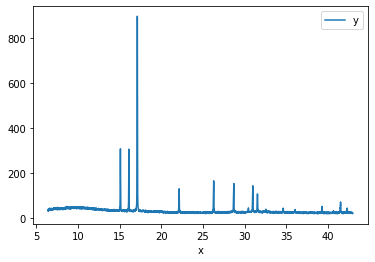

In [4]:
sep = '\t'

df = pd.read_csv(a[0], sep=sep, names=['x', 'y', 'e'])
df.plot.line(x='x', y='y')
plt.show()

Read files into a dataframe

In [5]:
def split_filename(filename):
    return filename.split('.')[-2].split('scan')[-1]

# Use all files or limit the number
maxfiles = len(a)
# maxfiles = 200

# Initialise the x column
df = pd.read_csv(a[0], sep=sep, names=['x', split_filename(a[0])], usecols=[0, 1])

# Initialise the other columns
for i in range(maxfiles):
    df[split_filename(a[i])] = pd.read_csv(a[i], sep=sep, names=[split_filename(a[i])], usecols=[1])

Generate an interactive plot to view the data

In [10]:
vmin = df.min().min()
maxmax = df.max().max()
start = 40
end = 175

@interact(vmin=(0, maxmax, 10), vmax=(0, maxmax, 10), start=(1, end, 1), end=(0, end, 1))
def heatmap(vmin=1, vmax=200, start=1, end=end):
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(
        df.iloc[:, start:end],
        extent = [0, df.shape[1], df['x'][0], df['x'][df.index[-1]]],
        norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_aspect('auto')
    ax.set_xlabel('pattern #')
    ax.set_ylabel('tth')
    # plt.show()

interactive(children=(FloatSlider(value=1.0, description='vmin', max=1748.82803359, step=10.0), FloatSlider(va…

Generate a static plot

Text(0, 0.5, 'tth')

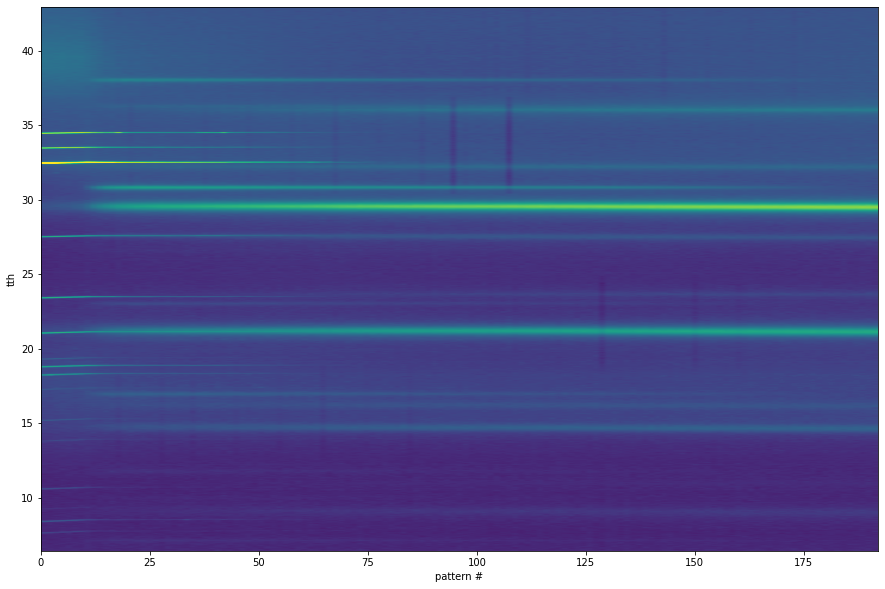

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(
    df.iloc[:, start:end],
    extent = [0, df.shape[1], df['x'][0], df['x'][df.index[-1]]],
    norm=LogNorm(vmin=20, vmax=180))
ax.set_aspect('auto')
ax.set_xlabel('pattern #')
ax.set_ylabel('tth')

Apply non-negative matrix factorization (NMF) to decompose data. 

Number of components needs to be determined from experiment expectations

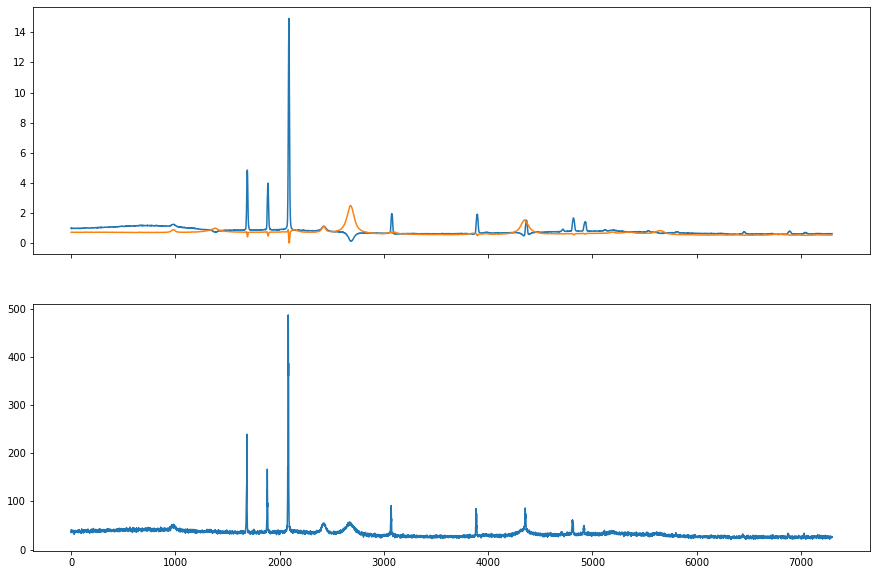

In [17]:
from sklearn.decomposition import NMF

# Choose region of data where peaks are not undergoing thermal shifts (here frame 40-175)
X = df.iloc[:, 40:175].to_numpy()

# Some values smaller than 0 - set to 0
X[X < 0] = 0

# X = np.transpose(X)

n_components= 2
transformer = NMF(n_components=n_components)#, random_state=0)
X_transformed = transformer.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10), sharex=True)

X_out = pd.DataFrame(X_transformed)
for i in range(n_components):
    ax1.plot(X_out[i].ewm(span=5).mean()) # with smoothing
    # X_out[i].plot(figsize=(15, 5)) # with smoothing
ax2.plot(df['50']) # Plot an example frame of real data to compare

# plt.ylim(0,10)
# plt.xlim(0,len(a))
plt.show()

Obtain the other component of the NMF corresponding to the quantities of the components above, over time

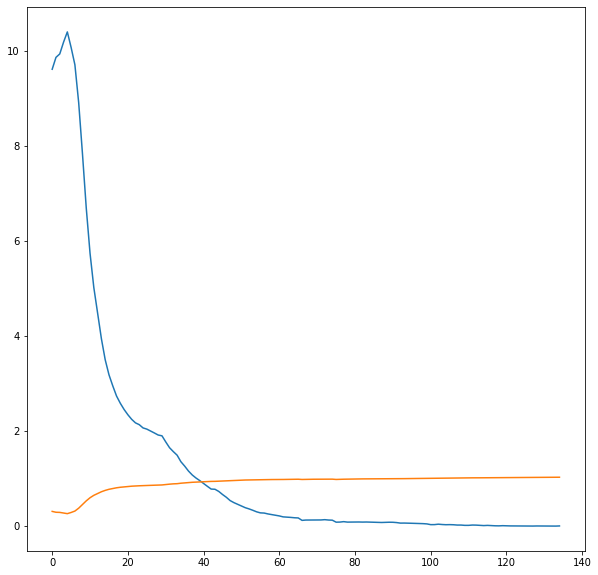

In [18]:
XT = np.transpose(X)
XT[XT < 0] = 0

# n_components= 2
transformer = NMF(n_components=n_components)#, random_state=0)
X_transformed = transformer.fit_transform(XT)

X_out = pd.DataFrame(X_transformed)
for i in range(n_components):
    X_out[i].ewm(span=5).mean().plot(figsize=(10, 10)) # with smoothing
    # X_out[i].plot(figsize=(15, 5)) # with smoothing

# plt.ylim(0,10)
# plt.xlim(0,len(a))
plt.show()

Tried taking the NMF of the log of the data rather than the absolute data to even out extremes, code below

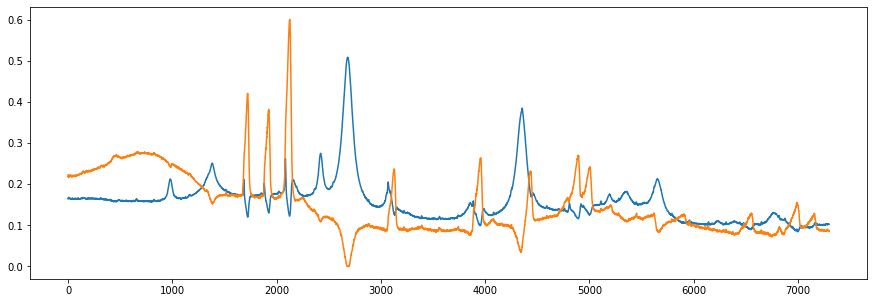

In [19]:
from sklearn.decomposition import NMF

X = df.iloc[:, 1:].to_numpy()

# Some values smaller than 0 - set to 0
X[X < 0] = 0

# Take the logs
X = np.log10(X)

X[X == -np.Inf] = 0
X[X < 0] = 0
X = X - X.min()

# X = np.transpose(X)

n_components= 2
transformer = NMF(n_components=n_components)#, random_state=0)
X_transformed = transformer.fit_transform(X)

X_out = pd.DataFrame(X_transformed)
for i in range(n_components):
    X_out[i].ewm(span=5).mean().plot(figsize=(15, 5)) # with smoothing
    # X_out[i].plot(figsize=(15, 5)) # with smoothing

# plt.ylim(0,1)
# plt.xlim(0)
plt.show()

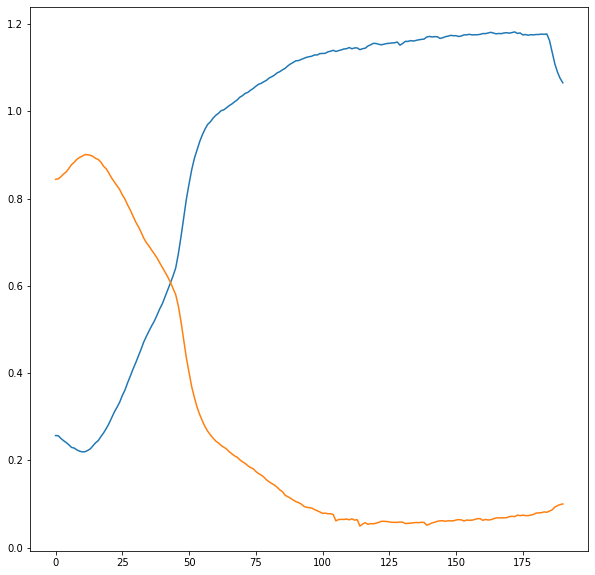

In [21]:
XT = np.transpose(X)
XT[XT < 0] = 0

# n_components= 2
transformer = NMF(n_components=n_components)#, random_state=0)
X_transformed = transformer.fit_transform(XT)

X_out = pd.DataFrame(X_transformed)
for i in range(n_components):
    X_out[i].ewm(span=5).mean().plot(figsize=(10, 10)) # with smoothing
    # X_out[i].plot(figsize=(15, 5)) # with smoothing

# plt.ylim(0,10)
# plt.xlim(0,len(a))
plt.show()

Plot of log(data)

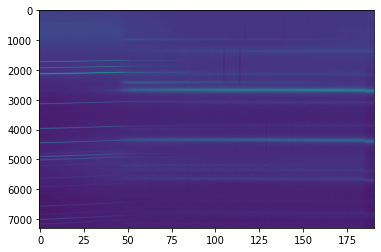

In [20]:
plt.imshow(X, aspect='auto')